In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 27)]
train_df = pd.read_csv('./dataset/train_FD001.txt', sep='\s+', header=None, names=column_names)
test_df = pd.read_csv('./dataset/test_FD001.txt', sep='\s+', header=None, names=column_names)
true_rul = pd.read_csv('./dataset/RUL_FD001.txt', header=None)

In [3]:
train_df = train_df.dropna(axis=1, how="all")
test_df = test_df.dropna(axis=1, how="all")

In [6]:
train_df.head()

,engine_id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [10]:
# Number of cycles for each engine in training dataset to failure
train_num_cycles_to_failure = train_df.groupby("engine_id")["cycle"].count()
train_num_cycles_to_failure

engine_id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64

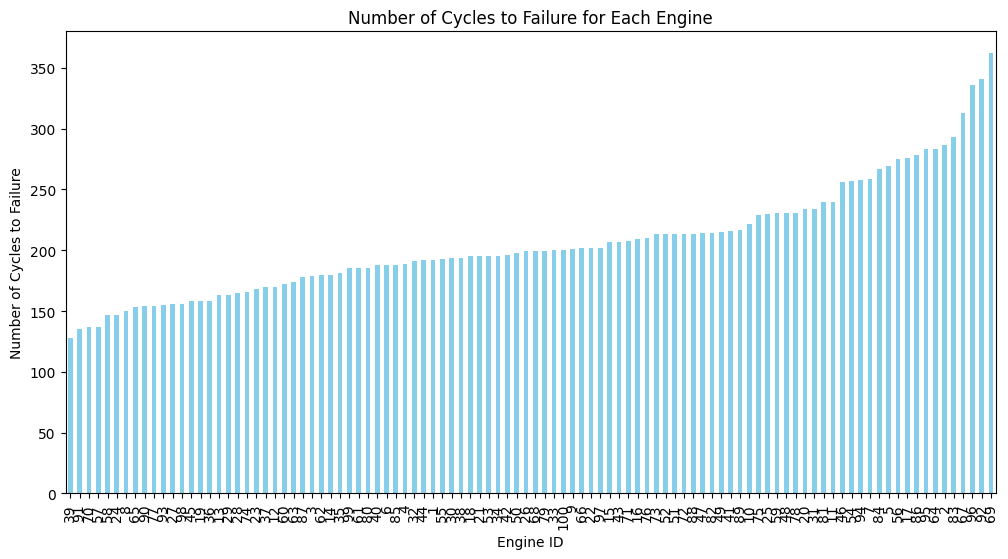

In [11]:
# Visualizing run to failure for all engines
# Sort values for better visualization
train_num_cycles_to_failure = train_num_cycles_to_failure.sort_values()

# Plotting
plt.figure(figsize=(12, 6))
train_num_cycles_to_failure.plot(kind='bar', color='skyblue')
plt.title("Number of Cycles to Failure for Each Engine")
plt.xlabel("Engine ID")
plt.ylabel("Number of Cycles to Failure")
plt.show()

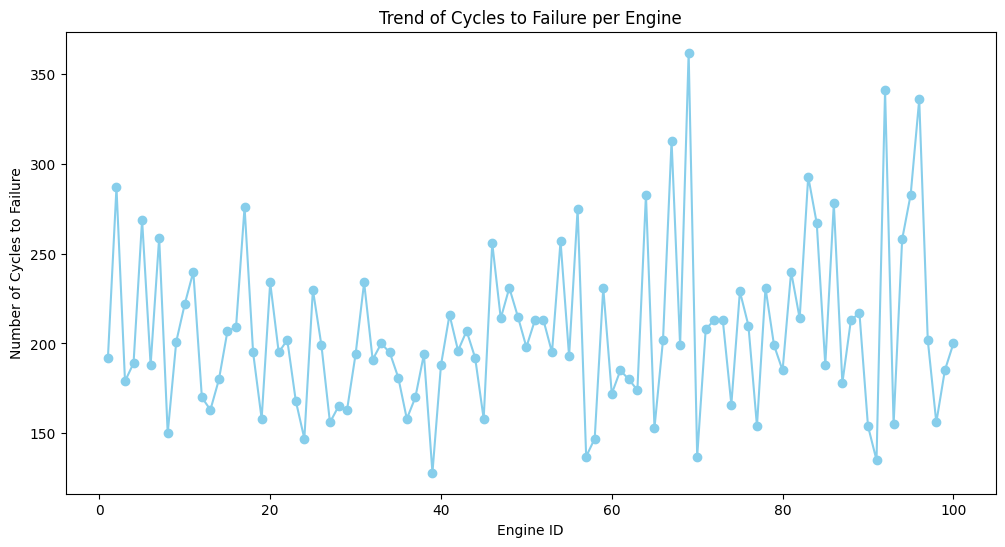

In [12]:
plt.figure(figsize=(12, 6))
train_num_cycles_to_failure.sort_index().plot(kind='line', marker='o', color='skyblue')
plt.title("Trend of Cycles to Failure per Engine")
plt.xlabel("Engine ID")
plt.ylabel("Number of Cycles to Failure")
plt.show()

In [28]:
def plot_linear_degradation(max_cycles):
    linear_degradation = np.arange(max_cycles - 1, -1, -1)
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    plt.plot(linear_degradation)
    plt.title("Engine 1")

In [29]:
def plot_piecewise_degradation(max_cycles, early_rul):
    early_rul_duration = max_cycles - early_rul
    piecewise_linear_degradation = np.append(early_rul * np.ones(shape=(early_rul_duration, )), np.arange(early_rul - 1, -1, -1))
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    plt.plot(piecewise_linear_degradation)
    plt.title("Engine 1")

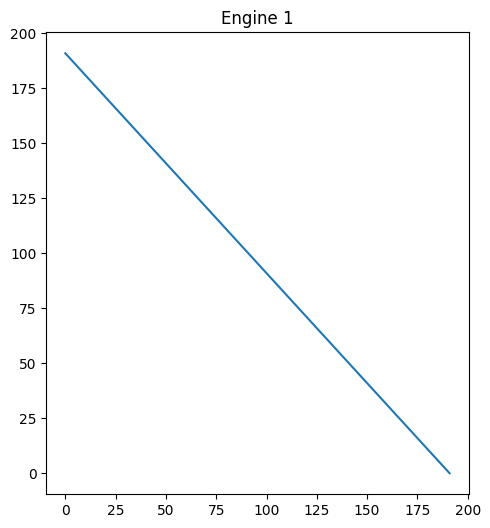

In [30]:
plot_linear_degradation(192)

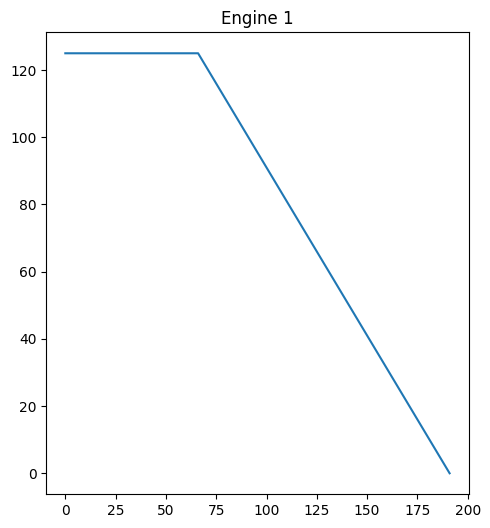

In [31]:
plot_piecewise_degradation(192, 125)

In [39]:
max_cycles = train_df.groupby("engine_id")["cycle"].max().mean()
print(max_cycles)

128


In [ ]:
import ruptures as rpt
# Group by engine unit
engine_units = train_df['engine_id'].unique()

# Define the cycles to analyze
early_cycles = 120  # Number of cycles for calculating baseline
fig, axes = plt.subplots(len(engine_units), 1, figsize=(10, 5 * len(engine_units)))
# fig.suptitle('Sensor Degradation Patterns Across Selected Engines')
for i, engine in enumerate(engine_units):
    engine_data = train_df[train_df['engine_id'] == engine]

    # Calculate baseline for the early stage - sensor 2 only
    baseline = engine_data.iloc[:early_cycles][['sensor2']].mean()
    baseline_std = engine_data.iloc[:early_cycles][['sensor2']].std()

    # Plot key sensor data in the subplot
    axes[i].plot(engine_data['cycle'], engine_data['sensor2'], label='Sensor 2')
    axes[i].set_xlabel('Cycle')
    axes[i].set_ylabel('Sensor Values')
    axes[i].set_title(f'Engine {engine} - Sensor Degradation')
    axes[i].legend()

    # Detect significant changes using change-point detection (e.g., CUSUM)
    signal = engine_data['sensor1'].values
    model = "l2"  # Model type for change-point detection
    algo = rpt.Pelt(model=model).fit(signal)
    change_points = algo.predict(pen=10)

    # Overlay detected change-points on the plot
    for cp in change_points:
        axes[i].axvline(x=cp, color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
fig.subplots_adjust(top=0.9)
plt.show()

# Notes: From change point detection algorithm, can see that sensor 2 values starts changing when around 120
# thats how the range 120 - 130 came about
# through observation of sensors

In [ ]:
# Assume stable phase to be 120 -> early detection better
